In [ ]:
Data Generation (Synthetic Dataset)

In [2]:
import random
import torch

# Parameters
dataset_size = 10000
seq_len = 10
vocab_size = 20

def generate_dataset(size, length, vocab):
    data = []
    for _ in range(size):
        seq = [random.randint(1, vocab - 1) for _ in range(length)]
        data.append((seq, list(reversed(seq))))
    return data

data = generate_dataset(dataset_size, seq_len, vocab_size)

# Create token-to-index and index-to-token mappings
token2idx = {str(i): i for i in range(vocab_size)}
idx2token = {i: str(i) for i in range(vocab_size)}


Dataset Preprocessing

In [3]:
from torch.utils.data import Dataset, DataLoader

class SeqDataset(Dataset):
    def __init__(self, data):
        self.data = data

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        src, tgt = self.data[idx]
        return torch.tensor(src), torch.tensor(tgt)

dataloader = DataLoader(SeqDataset(data), batch_size=32, shuffle=True)

Define Encoder, Decoder, and Attention Modules

In [4]:
import torch.nn as nn

class Encoder(nn.Module):
    def __init__(self, input_dim, hidden_dim):
        super().__init__()
        self.embedding = nn.Embedding(input_dim, hidden_dim)
        self.rnn = nn.GRU(hidden_dim, hidden_dim, batch_first=True)

    def forward(self, src):
        embedded = self.embedding(src)
        outputs, hidden = self.rnn(embedded)
        return outputs, hidden

class Attention(nn.Module):
    def __init__(self, hidden_dim):
        super().__init__()
        self.attn = nn.Linear(hidden_dim * 2, 1)

    def forward(self, hidden, encoder_outputs):
        batch_size, seq_len, _ = encoder_outputs.size()
        hidden = hidden.unsqueeze(1).repeat(1, seq_len, 1)
        energy = self.attn(torch.cat((hidden, encoder_outputs), dim=2)).squeeze(2)
        return torch.softmax(energy, dim=1)

class Decoder(nn.Module):
    def __init__(self, output_dim, hidden_dim):
        super().__init__()
        self.embedding = nn.Embedding(output_dim, hidden_dim)
        self.rnn = nn.GRU(hidden_dim + hidden_dim, hidden_dim, batch_first=True)
        self.fc_out = nn.Linear(hidden_dim * 2, output_dim)
        self.attention = Attention(hidden_dim)

    def forward(self, input, hidden, encoder_outputs):
        input = input.unsqueeze(1)
        embedded = self.embedding(input)
        attn_weights = self.attention(hidden[-1], encoder_outputs)
        context = torch.bmm(attn_weights.unsqueeze(1), encoder_outputs)
        rnn_input = torch.cat((embedded, context), dim=2)
        output, hidden = self.rnn(rnn_input, hidden)
        output = self.fc_out(torch.cat((output.squeeze(1), context.squeeze(1)), dim=1))
        return output, hidden

Define Seq2Seq Wrapper

In [5]:
class Seq2Seq(nn.Module):
    def __init__(self, encoder, decoder):
        super().__init__()
        self.encoder = encoder
        self.decoder = decoder

    def forward(self, src, tgt):
        encoder_outputs, hidden = self.encoder(src)
        input = tgt[:, 0]
        outputs = []
        for t in range(1, tgt.size(1)):
            output, hidden = self.decoder(input, hidden, encoder_outputs)
            outputs.append(output.unsqueeze(1))
            input = tgt[:, t]
        return torch.cat(outputs, dim=1)

Training the Model

In [6]:
import torch.optim as optim

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

encoder = Encoder(vocab_size, 128).to(device)
decoder = Decoder(vocab_size, 128).to(device)
model = Seq2Seq(encoder, decoder).to(device)

optimizer = optim.Adam(model.parameters())
criterion = nn.CrossEntropyLoss()

losses = []

for epoch in range(10):
    total_loss = 0
    for src, tgt in dataloader:
        src, tgt = src.to(device), tgt.to(device)
        optimizer.zero_grad()
        output = model(src, tgt)
        output = output.view(-1, vocab_size)
        tgt = tgt[:, 1:].contiguous().view(-1)
        loss = criterion(output, tgt)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    losses.append(total_loss / len(dataloader))
    print(f"Epoch {epoch + 1}, Loss: {losses[-1]:.4f}")

Epoch 1, Loss: 1.4711
Epoch 2, Loss: 0.7883
Epoch 3, Loss: 0.6250
Epoch 4, Loss: 0.5305
Epoch 5, Loss: 0.4639
Epoch 6, Loss: 0.4036
Epoch 7, Loss: 0.3627
Epoch 8, Loss: 0.3228
Epoch 9, Loss: 0.3008
Epoch 10, Loss: 0.2690


Accuracy Evaluation

In [7]:
def evaluate_accuracy(model, dataloader):
    model.eval()
    correct = total = 0
    with torch.no_grad():
        for src, tgt in dataloader:
            src, tgt = src.to(device), tgt.to(device)
            output = model(src, tgt)
            preds = output.argmax(dim=-1)
            correct += (preds == tgt[:, 1:]).sum().item()
            total += torch.numel(tgt[:, 1:])
    model.train()
    return correct / total

accuracy = evaluate_accuracy(model, dataloader)
print(f"Accuracy: {accuracy * 100:.2f}%")

Accuracy: 91.16%


Plotting Loss Curve

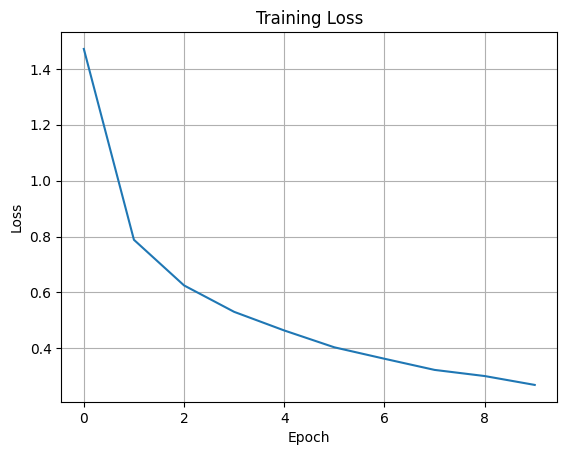

In [8]:
import matplotlib.pyplot as plt

plt.plot(losses)
plt.title("Training Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.grid(True)
plt.show()

In [10]:
import random
import torch

# Configuration
seq_len = 10
vocab_size = 20  # 0 is reserved for padding if used

# Generate a random input sequence
src_seq = [random.randint(1, vocab_size - 1) for _ in range(seq_len)]

# Generate the corresponding reversed target sequence
tgt_seq = src_seq[::-1]

# Convert to tensors (optional - if you want it in PyTorch format)
src_tensor = torch.tensor(src_seq, dtype=torch.long)
tgt_tensor = torch.tensor(tgt_seq, dtype=torch.long)

# Display
print(" Input Sequence (Source):", src_seq)
print(" Target Sequence (Reversed):", tgt_seq)


 Input Sequence (Source): [13, 2, 13, 9, 18, 1, 5, 3, 11, 3]
 Target Sequence (Reversed): [3, 11, 3, 5, 1, 18, 9, 13, 2, 13]
